## Exercises

Setup

In [2]:
import pandas as pd
import math
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
import random
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy import stats


df = pd.read_excel('/Users/ooganam/Desktop/individualprojects/foodsecurity/August2015.xls', sheet_name = None)
df.pop("Read_Me")
df.pop("Supplemental Data - County")
df.pop("Supplemental Data - State")
df.pop("LOCAL")
df.pop("INSECURITY")

x_categories = ["ACCESS", "ASSISTANCE", "HEALTH", "PRICES_TAXES", "RESTAURANTS", "STORES", "SOCIOECONOMIC"]
exclude = ["FIPS", "State", "County"]

def shuffle_in_place(array):
    array_len = len(array)
    assert array_len > 2, 'Array is too short to shuffle!'
    for index in range(array_len):
        swap = random.randrange(array_len - 1)
        array[[index,swap]] = array[[swap,index]]
    return array

countylist = [] #list of codes that correspond to different counties
variablenames = [] #list of variables in order that they appear in X matrix
variabledict = {}
X_all = [] #X matrix
Y_all = []

targetvar = "HEALTH"
#add all variable code names
for sheet in df:
    if sheet in x_categories:
        df[sheet].dropna(thresh = df[sheet].shape[1] - 20, inplace = True) #drop null values
        df[sheet].fillna(df[sheet].mean(), inplace=True)
        for variable in df[sheet].columns:
            if sheet != targetvar:
                if variable not in exclude:
                    variablenames.append(variable) #add all variable names

#made dictionary mapping variable code names to actual variable names
for row in df["Variable List"].itertuples():
    if row.Code in variablenames:
        if row.Category != targetvar: #change this to run black/white obese part
            variabledict[row.Code] = row.Name





In [3]:
for sheet in df: #for each sheet
    if sheet in x_categories:  #if the sheet is one of the x variables
        temp = [] 
        for code in df[sheet]["FIPS"]:
            temp.append(code) 
        countylist.append(temp) #add all county codes to countylist

finalcountylist = set.intersection(*map(set, countylist)) #select only those counties that are contained in every spreadsheet
countybool = {county:[] for county in finalcountylist} #will map county codes to their corresponding data
yindex = 0
finalyindex = 0


#create 
for sheet in df:
    if sheet in x_categories:
        for row in df[sheet].itertuples():
            if row.FIPS in countybool:
                if sheet == targetvar:
                    countybool[row.FIPS].append(row.PCT_DIABETES_ADULTS13 + row.PCT_OBESE_ADULTS13)
                    finalyindex = yindex
                else:
                    for element in row[4:]:
                        countybool[row.FIPS].append(element)
        yindex += df[sheet].shape[1] - 3
                    


for county in countybool:
    temp = []
    for number in countybool[county]:
        temp.append(number)
    X_all.append(temp)

X_all = np.array(X_all)
print("PRE-SHUFFLE")
X_all = shuffle_in_place(X_all)
print("POST-SHUFFLE")

Y_all = X_all[:,finalyindex]
X_all = np.delete(X_all, finalyindex, axis = 1)

num_samples = len(Y_all)

sc = StandardScaler()
X_all = sc.fit_transform(X_all)

xtrain = X_all[0:2000]
xtest = X_all[2000:X_all.shape[0]]
Y_tr = Y_all[0:2000]
Y_te = Y_all[2000:num_samples]


PRE-SHUFFLE
POST-SHUFFLE


In [4]:
#BEFORE PCA
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import make_scorer
from sklearn import svm
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV

def predict(model, x, y, test):
    print(type(model))
    model.fit(x, y)
    
    Y_preds = model.predict(test)
    plt.scatter(Y_preds, Y_te)
    plt.xlabel("Predicted values")
    plt.ylabel("Actual Values")
    
    print("SCORE: ", r2_score(Y_te, Y_preds))
    importances=model.best_estimator_.feature_importances_
    #importances=model.feature_importances_
    indices=np.argsort(importances)[::-1]
    indices=indices[:10]
    # Print the feature ranking
    print("Feature ranking:")
    print(indices)
    for f in range(10):
        print(f, ":", variabledict[variablenames[indices[f]]], "Importance:", importances[indices[f]])
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [variablenames[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
# R2 Score



In [5]:
def lets_try(train,labels):
    results={}
    modeltypes = {}
    def test_model(clf):

        cv = KFold(n_splits=5,shuffle=True,random_state=45)
        r2 = make_scorer(r2_score)
        r2_val_score = cross_val_score(clf, train, labels, cv=cv,scoring=r2)
        scores=[r2_val_score.mean()]
        return scores

    clf = linear_model.LinearRegression()
    results["Linear"]=test_model(clf)
    modeltypes["Linear"] = clf
    
    clf = linear_model.Ridge()
    results["Ridge"]=test_model(clf)
    modeltypes["Ridge"] = clf
    
    clf = linear_model.BayesianRidge()
    results["Bayesian Ridge"]=test_model(clf)
    modeltypes["Bayesian Ridge"] = clf
    
    clf = linear_model.HuberRegressor(epsilon = 1, max_iter = 200)
    results["Hubber"]=test_model(clf)
    modeltypes["Hubber"] = clf
    
    clf = linear_model.Lasso(alpha=1e-4)
    results["Lasso"]=test_model(clf)
    modeltypes["Lasso"] = clf
    
    clf = AdaBoostRegressor()
    results["AdaBoost"]=test_model(clf)
    modeltypes["AdaBoost"] = clf
    
    clf = svm.SVR()
    results["SVM RBF"]=test_model(clf)
    modeltypes["SVM RBF"] = clf
    
    clf = svm.SVR(kernel="linear")
    results["SVM Linear"]=test_model(clf)
    modeltypes["SVM Linear"] = clf
    
    results = pd.DataFrame.from_dict(results,orient='index')
    results.columns=["R Square Score"] 
    results=results.sort_values(by = ["R Square Score"], ascending=False)
    results.plot(kind="bar",title="Model Scores")
    axes = plt.gca()
    axes.set_ylim([0.5,1])
    return results, modeltypes

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

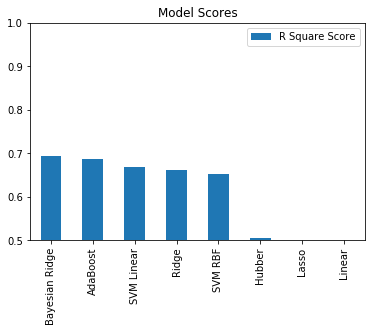

In [6]:
mod_list, mod_dict = lets_try(xtrain, Y_tr)

<class 'sklearn.model_selection._search.RandomizedSearchCV'>
Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 53.0min finished


SCORE:  0.7757321433467954
Feature ranking:
[ 92  91  99 100 154  14 112 157 123  96]
0 : Expenditures per capita, restaurants, 2012* Importance: 0.04994773733782565
1 : Expenditures per capita, restaurants, 2007* Importance: 0.0337130978049844
2 : SNAP benefits per capita, 2010 Importance: 0.031010688451937943
3 : SNAP benefits per capita, 2015 Importance: 0.030452996924221067
4 : Median household income, 2015 Importance: 0.02802983171190386
5 : Households, no car & low access to store (%), 2015 Importance: 0.027145756974629166
6 : National School Lunch Program participants (% pop), 2009* Importance: 0.024916904361488478
7 : Child poverty rate, 2015 Importance: 0.0240268566143358
8 : Summer Food Service Program participants (% pop), 2015* Importance: 0.02331188109620191
9 : SNAP participants (% pop), 2012* Importance: 0.02178722054922393


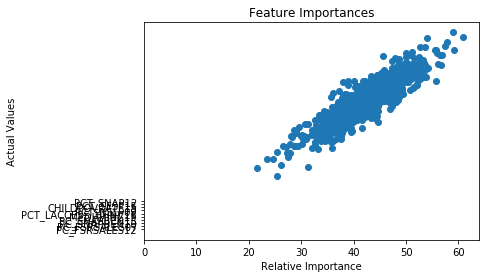

In [59]:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 4, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
predict(rf_random, xtrain, Y_tr, xtest)

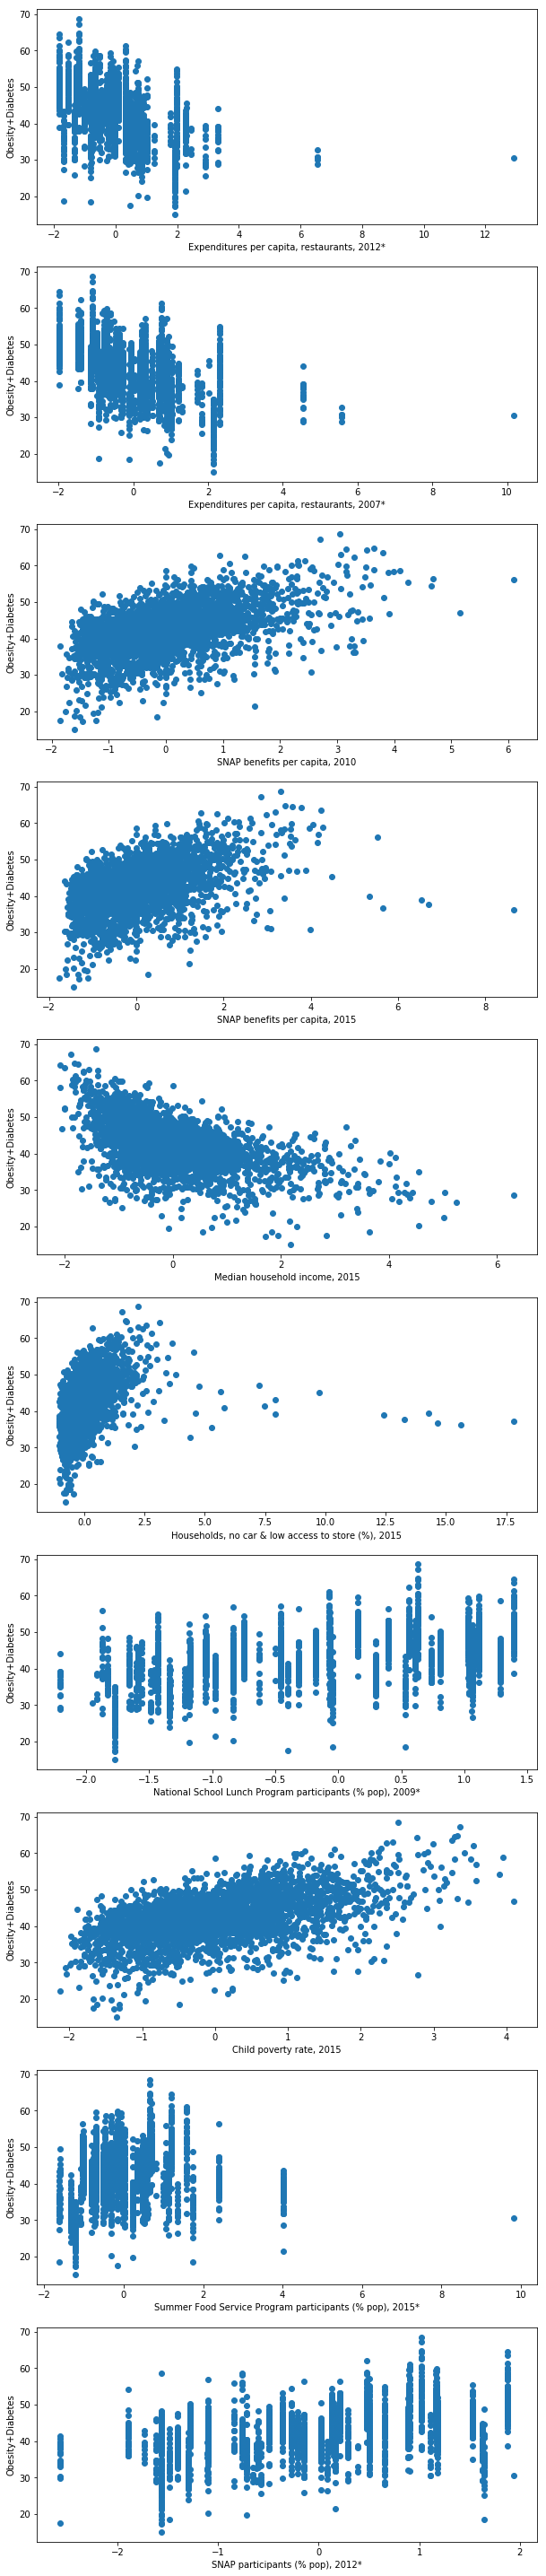

In [113]:
varlist = [92, 91, 99, 100, 154, 14, 112, 157, 123, 96]

length = int(len(varlist))

plt.figure(figsize=(10, 40))
for j in range(length):
    plt.subplot(length, 1, j+1)
    
    plt.scatter(X_all[:,varlist[j]], Y_all)
    plt.subplot(length,1, j+1).set_xlabel(variabledict[variablenames[varlist[j]]])
    plt.subplot(length,1, j+1).set_ylabel("Obesity+Diabetes")
    
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.2, wspace=0.4)
plt.show()


